# kaggle Titanic project: Machine learning from disaster
---

## Defining the problem

As is said in kaggle.com, "The competition is simple: use machine learning to create a model that **predicts which passengers survived** the Titanic shipwreck."

We are provided with a training set containing data about the passengers (11 features and the label). We'll need this to perform model selection and validation. We also have a smaller test set. The final model will use it to make predictions. The labels are unknown, we are only give a data set with the attributes.

The output is a binary variable: Survived->Yes/No. That means it's a classification task. The reference metric is accuracy.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection

In [26]:
df = pd.read_csv(r'C:\Users\Diego\Desktop\pyprojects\a medias\titanic\titanictrain.csv')
display(df.head())
df.describe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Preparation

* Basic Exploratory Data Analysis (EDA)

In [27]:
display(df.apply(lambda col:col.isna().sum()))

print('NA Embarked before')
display(df['Embarked'].isna().sum())

df.dropna(subset=['Embarked'],inplace=True)
df.reset_index(inplace=True)

print('NA Embarked after')
display(df['Embarked'].isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

NA Embarked before


2

NA Embarked after


0

"Cabin" has so many missing values that it will be dropped. On the other hand, the 177 missing values of "Age" will be imputed (several methods are tried later). The "Embarked" values are just deleted.

* Graphical EDA

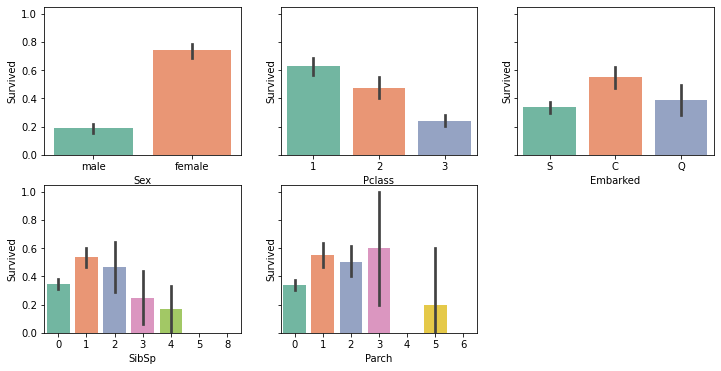

In [28]:
from itertools import product

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
fig.delaxes(axes[1,2])
for ax,feature in zip(product(range(2),range(3)),
                      ['Sex','Pclass','Embarked','SibSp','Parch']):
     sns.barplot(ax=axes[ax],x=feature,y='Survived',palette='Set2',data=df)

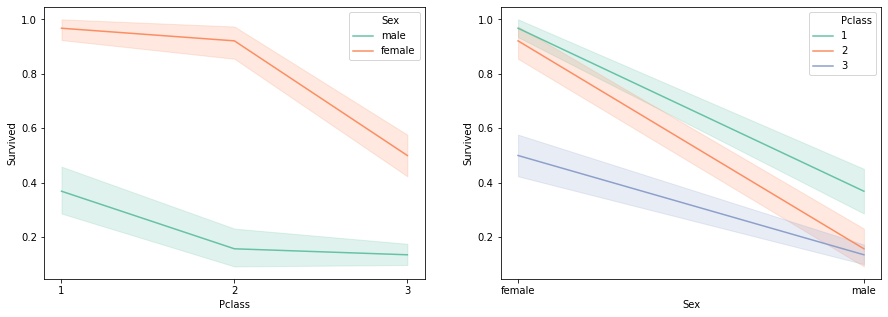

In [45]:
# maybe interaction sex-class?
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(ax=ax1,x='Pclass',y='Survived',hue='Sex',palette='Set2',data=df).set(xticks=[1,2,3]);
sns.lineplot(ax=ax2,x='Sex',y='Survived',hue='Pclass',palette='Set2',data=df);


In [77]:
df.groupby(['Sex','Pclass'])['Survived'].agg(['count','mean','var'])

count      mean       var
Sex    Pclass                           
female 1          92  0.967391  0.031892
       2          76  0.921053  0.073684
       3         144  0.500000  0.251748
male   1         122  0.368852  0.234724
       2         108  0.157407  0.133870
       3         347  0.135447  0.117439

In [88]:
from statsmodels.api import Logit # to perform logistic regression and show summary output
from patsy import dmatrix,dmatrices # to easily build the design matrix
y,X = dmatrices('Survived~C(Sex)*C(Pclass)',data=df)
Logit(y,X).fit().summary()

Optimization terminated successfully.
         Current function value: 0.448800
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            5
Date:                Tue, 07 Sep 2021   Pseudo R-squ.:                  0.3254
Time:                        23:57:39   Log-Likelihood:                -398.98
converged:                       True   LL-Null:                       -591.41
Covariance Type:            nonrobust   LLR p-value:                 5.452e-81
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.3900      0.587      5.775      0.000       2.240       4.541
C(Sex)[T.male]                   -3.9272      0.616     -6.373      0.000      -5.135      -2.719
C(Pclass)[T.2]                   -0.9333      0.725     -1.287      0.198      -2.354       0.488
C(Pclass)[T.3]                   -3.3900      0.610     -5.556      0.000      -4.586      -2.194
C(Sex)[T.male]:C(Pclass)[T.2]    -0.2072      0.794     -0.261      0.794      -1.764       1.349
C(Sex)[T.male]:C(Pclass)[T.3]     2.0735      0.657      3.154      0.002       0.785       3.362
=================================================================================================
"""

As can be seen, including an interaction term in the model might be justified. We'll take this into account later

The rest of data preparation and preprocessing (Imputation, scaling, feature selection) is done jointly with model selection using ```Pipeline```. 

## Model selection

In [109]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,RobustScaler,QuantileTransformer,StandardScaler,PolynomialFeatures
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,brier_score_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from sklearn.model_selection import cross_val_score

* Baseline model 1 (worst possible)

The "coin model" can be considered the worst one. For each instance, it predicts survival with a probability of 0.5. The expected accuracy,therefore, is  0.5.

* Baseline model 2

This represents a model which is fit directly to the data, without doing any kind of preprocessing or data splitting

In [125]:
test = pd.read_csv(r'C:\Users\Diego\Desktop\pyprojects\a medias\titanic\titanictest.csv')

predictors = ['Age','Fare','Sex','Pclass','Embarked','SibSp','Parch']
num_vars = ['Age','Fare']
cat_vars = ['Sex','Pclass','Embarked','SibSp','Parch']
to_dummy = ColumnTransformer([('categ_cols',OneHotEncoder(handle_unknown='ignore'),cat_vars)])
model = make_pipeline(to_dummy,LogisticRegression(max_iter=1000))

test['Survived'] = model.fit(df[predictors],df['Survived']).predict(test[predictors])
preds = test[['PassengerId','Survived']]
preds.to_csv('predictions.csv',index=False)

The predictions were submitted to kaggle and it seems that the accuracy is 0.77. Let's see if it can be improved

* Proposed algorithms

I've decided to test three diferent algorithms: logistic regression, K-nearest neighbors and decision tree. The reason is that they are simple and I know them better than others like Suppor Vector Machines, for example.

Initially I tried each one separately and tune the parameters manually. I submitted the predictions of some of them to kaggle and the final accuracy was usually something about 0.75. After some experimentation and a few iterations I designed the following pipeline to test them simultaneously.

In [98]:
imputer = [SimpleImputer(),
           KNNImputer()]
imputer_params = [{'preprocess_cols__1__numeric_cols__imputer__strategy':['mean','median']},
                  {'preprocess_cols__1__numeric_cols__imputer__n_neighbors':range(1,11)}]

# ----------------------
scaler = [RobustScaler(),
          QuantileTransformer(n_quantiles=100),
          StandardScaler()]

# ----------------------
model = [LogisticRegression(max_iter=1000),
         KNeighborsClassifier(),
         DecisionTreeClassifier(max_depth=10,class_weight='balanced')]

model_params = [{'model__C':np.logspace(-3,2,10)}, # for log reg
               {'model__n_neighbors':range(1,11)}, # for knn
               {'model__min_samples_leaf':range(1,21)}] # for decision tree


In [99]:
cat_transformer = Pipeline([
            ('dummy',OneHotEncoder(handle_unknown='ignore')),
            ('interaction',PolynomialFeatures(degree=2,interaction_only=True)),
            ('feature_selection',VarianceThreshold(threshold=0.16))
        ])

cv_models = []
for i in range(len(imputer)):
    for s in range(len(scaler)):
        for m in range(len(model)):
            num_transformer = Pipeline([
                ('imputer', imputer[i]),
                ('scaler', scaler[s])])
            
            
            pipe = Pipeline([
                ('preprocess_cols',Pipeline([
                    ('1',ColumnTransformer([
                        ('numeric_cols',num_transformer,num_vars),
                        ('categ_cols',cat_transformer,cat_vars)
                    ]))
                ])),
                ('model',model[m])
            ])
            
            cv = GridSearchCV(pipe,
                              param_grid={**imputer_params[i],**model_params[m]},
                              cv=10,
                              n_jobs=-1)
            
            cv.fit(df[predictors],df['Survived'])
            
            cv_models.append(cv)

In [104]:
cv_scores = [c.best_score_ for c in cv_models]
print(f'mean accuracy of all models:{np.asarray(cv_scores).mean()}')

# best = cv_scores.index(max(cv_scores))
cv_names = [c.best_estimator_.named_steps['model'] for c in cv_models]
display(cv_names)

# get the best of each type
bests = [cv_models[pd.Series(cv_scores)[np.arange(n,18,3)].idxmax()].best_estimator_ for n in range(3)]

mean accuracy of all models:0.8131533026898196


[LogisticRegression(C=2.1544346900318843, max_iter=1000),
 KNeighborsClassifier(n_neighbors=6),
 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=12),
 LogisticRegression(C=2.1544346900318843, max_iter=1000),
 KNeighborsClassifier(n_neighbors=8),
 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=11),
 LogisticRegression(C=2.1544346900318843, max_iter=1000),
 KNeighborsClassifier(n_neighbors=8),
 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=8),
 LogisticRegression(C=2.1544346900318843, max_iter=1000),
 KNeighborsClassifier(n_neighbors=6),
 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                        min_samples_leaf=10),
 LogisticRegression(C=2.1544346900318843, max_iter=1000),
 KNeighborsClassifier(n_neighbors=6),
 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                      

I explored the models a little and they are very similar, so maybe an ensemble classifier can be appropiate.

In [105]:
voting_model = VotingClassifier(estimators=[('logistic',bests[0]),
                                            ('knn',bests[1]),
                                            ('DT',bests[2])],
                               voting='soft',
                               weights=[0.5,0.4,0.1]) # weights adjusted after some tuning


cross_val_score(voting_model,df[predictors],df['Survived']).mean()

0.8177870881736812

## Model evaluation

The final model is evaluated using the test data provided by kaggle.

In [107]:
test = pd.read_csv(r'C:\Users\Diego\Desktop\pyprojects\a medias\titanic\titanictest.csv')
final_model = voting_model
test['Survived'] = final_model.fit(df[predictors],df['Survived']).predict(test[predictors])
preds = test[['PassengerId','Survived']]
preds

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [108]:
preds.to_csv('predictions.csv',index=False)

The accuracy achieved was 0.78, not much better than the baseline model 2 and worse than the best performing models that achieve around 0.80 accuracy

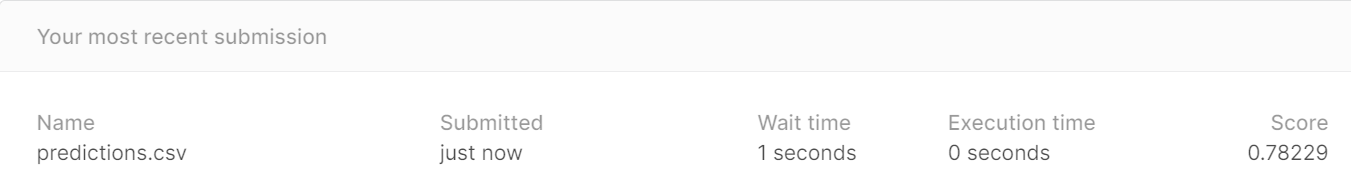

## Comments

I did no feature engineering because I just wanted to practice sklearn but from what I've seen, that's the key of success